<a href="https://colab.research.google.com/github/eroali/DeepLearning/blob/main/DL_M6_Transfer_learning_module6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!wget https://www.dropbox.com/s/y9hooknj3zmeqmw/data.zip

--2021-01-04 22:08:13--  https://www.dropbox.com/s/y9hooknj3zmeqmw/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/y9hooknj3zmeqmw/data.zip [following]
--2021-01-04 22:08:13--  https://www.dropbox.com/s/raw/y9hooknj3zmeqmw/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3f3060c13edb4870802d7c2a1b.dl.dropboxusercontent.com/cd/0/inline/BGbu9_BiOT4sld8pu4QitUr4V6-3-T70SPuHui0QxB_XUUKTBP3zEP3kQGXmfYeHCC2LX9rq-sGlomEA5AK6m50BFnDDU1IEBZBkR4w3V6efZ4JpJ8Ld1HIZnv_y7pvuXYs/file# [following]
--2021-01-04 22:08:14--  https://uc3f3060c13edb4870802d7c2a1b.dl.dropboxusercontent.com/cd/0/inline/BGbu9_BiOT4sld8pu4QitUr4V6-3-T70SPuHui0QxB_XUUKTBP3zEP3kQGXmfYeHCC2LX9rq-sGlomEA5AK6m50BFnDDU1IEBZBkR4w3V6efZ4JpJ8Ld1HIZnv_

In [24]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace data/test/cats/cat.250.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [25]:
# Base variables
import os
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

train_size, validation_size, test_size = 200, 100, 100

img_width, img_height = 224, 224  # Default input size for VGG16

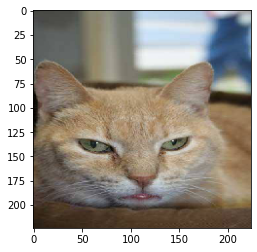

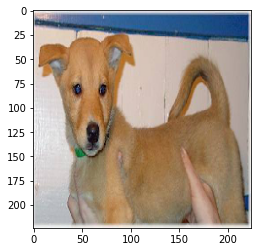

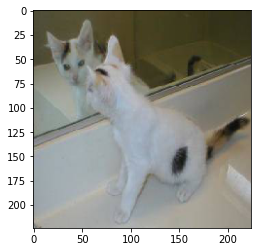

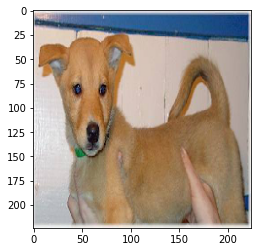

In [26]:
# Show pictures
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_cats_dir)
    show_pictures(train_dogs_dir)

In [27]:
# Instantiate convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [28]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [30]:
# Debug
print(train_features)
print(train_labels)

[[[[0.44275412 0.         0.         ... 0.         0.86214584
    0.        ]
   [0.52611566 0.         0.         ... 0.         0.38384843
    0.        ]
   [0.4996056  0.         1.11840892 ... 0.         0.19533432
    0.        ]
   ...
   [0.         0.         0.60238343 ... 0.         0.64213866
    0.        ]
   [0.         0.         0.         ... 0.         0.68441129
    0.        ]
   [0.28931913 0.         0.         ... 0.         0.71480548
    0.        ]]

  [[0.39049777 0.         0.         ... 0.         0.77044439
    0.        ]
   [0.10989162 0.         0.27612871 ... 0.         0.98910242
    0.        ]
   [0.17711771 0.         1.20151758 ... 0.06476191 0.77525175
    0.        ]
   ...
   [0.06019258 0.         0.96510273 ... 0.13698843 1.01510382
    0.        ]
   [0.26741001 0.         0.58387733 ... 0.         1.32150197
    0.        ]
   [0.19644722 0.         0.48970604 ... 0.         0.94954324
    0.        ]]

  [[0.10363773 0.         0.      

In [31]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [33]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
7/7 [==============================] - 1s 34ms/step - loss: 3.9302 - acc: 0.5085 - val_loss: 0.5907 - val_acc: 0.6900
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.7862 - acc: 0.7164 - val_loss: 0.6281 - val_acc: 0.6400
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.5155 - acc: 0.7731 - val_loss: 0.4545 - val_acc: 0.8300
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.2267 - acc: 0.9024 - val_loss: 0.3841 - val_acc: 0.8600
Epoch 5/100
7/7 [==============================] - 0s 33ms/step - loss: 0.2311 - acc: 0.9074 - val_loss: 0.3624 - val_acc: 0.8500
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1299 - acc: 0.9587 - val_loss: 0.3935 - val_acc: 0.8500
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0943 - acc: 0.9664 - val_loss: 0.3821 - val_acc: 0.8300
Epoch 8/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0658 - acc: 0.99

In [34]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice(['/content/data/test/cats', '/content/data/test/dogs'])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Cat')
        else:
            print('Dog')

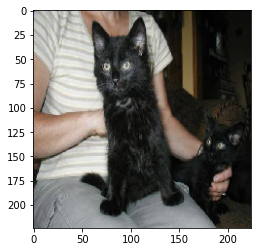

Cat


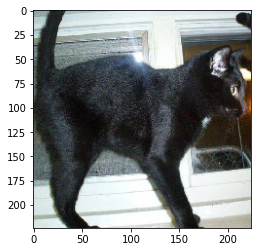

Cat


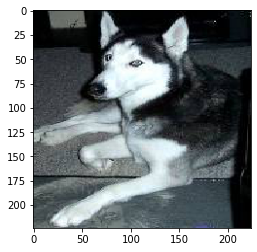

Cat


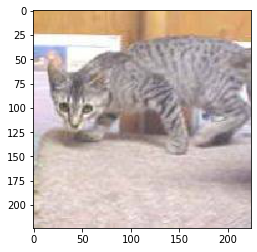

Cat


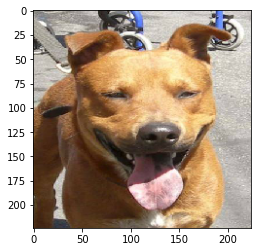

Dog


In [35]:
# Visualize predictions
visualize_predictions(model, 5)

In [36]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [ ]:
!pip install scikit-learn

In [37]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(300,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [39]:
# Save model
model.save('dogs_cat_svm.h5')

In [40]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
print("\nAccuracy score (standard deviation):")
print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))


Accuracy score (mean):
0.86

Accuracy score (standard deviation):
0.05537749241945382


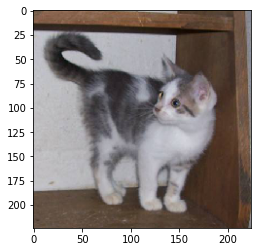

Dog


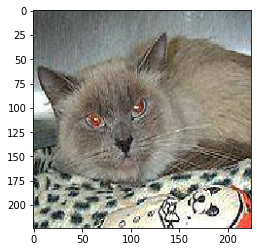

Cat


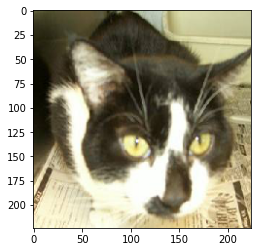

Cat


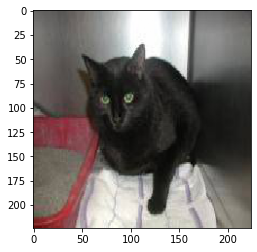

Cat


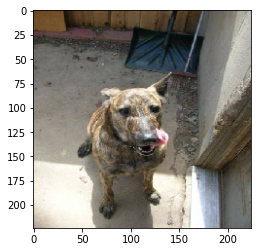

Dog


In [41]:
# Visualize predictions
visualize_predictions(clf, 5)